In [1]:
pwd

'/mnt/md0/isshamie/Projects/Mito_Trace/workflow/notebooks/variant_types'

In [2]:
#dat_indir="data/CHIP_april08_2021/MTblacklist/chrM/pseudo/minC200_minAF0.01/numC100000_ispropFalse/"
#vars_type_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/anno_variants/varsType.tsv"
# mult_dir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/"
# outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/vars_type/"
# sample_names="Control,Flt3l,Input"

indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init"
outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/variantTypes/"
N_DONORS=2
#DONOR = 1


verbose=False

In [3]:
from os.path import join, exists, dirname
import os
from glob import glob
import pickle
import mplh.cluster_help as ch
import os
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
print(vireoSNP.__version__)

import pandas as pd
import seaborn as sns
from vireoSNP import Vireo
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

from src.external.pyvenn import venn

%load_ext autoreload
%autoreload 2
import src.utils.variant_utils as vu
from src.utils.data_io import wrap_load_mtx_df

fig_utils from mplh
0.5.6


In [4]:
cells_meta = pd.read_csv(join(dirname(indir), "cells_meta.tsv"), sep="\t")
#cells_meta["lineage"] = cells_meta.apply(lambda x: f'{x["donor"]}_{x["lineage"]}', axis=1)
cells_meta["donor"] = cells_meta["donor"].astype('Int32')
cells_meta = cells_meta.dropna(subset=["donor"])
cells_meta

,index,ID,raw ID,new index,condition,donor,donor_index
0,0,AAACGAAAGAATCAAC-1_Control,AAACGAAAGAATCAAC-1,1,Control,0,1.0
1,1,AAACGAAAGAATCAGT-1_Control,AAACGAAAGAATCAGT-1,2,Control,1,1.0
2,2,AAACGAAAGCATACCT-1_Control,AAACGAAAGCATACCT-1,3,Control,1,2.0
3,3,AAACGAAAGCGAGAAA-1_Control,AAACGAAAGCGAGAAA-1,4,Control,0,2.0
4,4,AAACGAAAGTACAGAT-1_Control,AAACGAAAGTACAGAT-1,5,Control,0,3.0
...,...,...,...,...,...,...,...
18228,18228,TTTGTGTGTTTCTTAC-1_Input,TTTGTGTGTTTCTTAC-1,18229,Input,0,9020.0
18229,18229,TTTGTGTTCCTGAAAC-1_Input,TTTGTGTTCCTGAAAC-1,18230,Input,0,9021.0
18230,18230,TTTGTGTTCGGGAAAC-1_Input,TTTGTGTTCGGGAAAC-1,18231,Input,0,9022.0
18231,18231,TTTGTGTTCGGGACAA-1_Input,TTTGTGTTCGGGACAA-1,18232,Input,1,8275.0


## Loop through donor af matrix

In [5]:
def get_high_variants(df, thresh, pct_thresh):
    """ Remove rows that have an average higher than threshold

    :param df:
    :param thresh:
    :return:
    """
    n_pct = pct_thresh*df.shape[0]
    return df.loc[:,((df>thresh).sum()>n_pct)].columns.values


# g = sns.clustermap(AF_df.loc[:, donor_vars])
# g.fig.savefig(fname=join(outdir, f"donor_variants.pdf"))
#plt.savefig(join(outdir, "donor_vars.png"))

In [6]:
all_af = []
all_dp = []
all_donor_vars = {}
all_vcf = []
for d, val in cells_meta.groupby("donor"):
    af_indir = join(indir, f"donor{d}")
    all_af.append(pd.read_csv(join(af_indir, "af.tsv"), index_col=0, sep="\t"))
    all_dp.append(pd.read_csv(join(af_indir, "dp.tsv"), index_col=0, sep="\t"))
    donor_vars = get_high_variants(all_af[-1], thresh=0.8, pct_thresh=0.9)
    all_donor_vars[d] = donor_vars
    print(f"number of donor vars: {len(donor_vars)}")
    all_vcf.append(pd.read_csv(join(af_indir, "cellSNP.base.vcf"),sep="\t"))
    all_vcf[-1]["donor"] = d
    all_vcf[-1] 
all_af = pd.concat(all_af, axis=0)
all_dp = pd.concat(all_dp, axis=0)

assert(not all_af.index.duplicated().any())
all_af

number of donor vars: 28
number of donor vars: 35


,10397G,10463C,10559G,10589A,11251G,11453A,11719A,11761T,11812G,13188T,...,750G,7598A,827G,8292A,8461T,8697A,8743A,8860G,930A,9899C
Cell,,,,,,,,,,,,,,,,,,,,,
AAACGAAAGAATCAAC-1_Control,1.0,0.0,0.0,0.882353,0.153846,0.0,0.000000,0.846154,0.054054,1.000000,...,1.0,1.000000,0.961538,0.866667,1.000000,0.0,0.0,1.0,0.0,0.000000
AAACGAAAGCGAGAAA-1_Control,1.0,0.0,0.0,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,1.000000,...,1.0,1.000000,1.000000,1.000000,0.838710,0.0,0.0,1.0,0.0,0.076923
AAACGAAAGTACAGAT-1_Control,0.0,0.0,0.0,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,1.000000,...,1.0,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.0,0.0,0.000000
AAACGAAAGTTAGCAA-1_Control,0.8,0.0,0.0,1.000000,0.000000,0.0,0.428571,0.700000,0.000000,0.818182,...,1.0,1.000000,1.000000,0.909091,1.000000,0.5,0.0,1.0,0.0,0.250000
AAACGAACACTCGCAG-1_Control,1.0,0.0,0.0,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,1.000000,...,1.0,0.928571,1.000000,1.000000,0.888889,0.0,0.0,1.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGTCAATGACTC-1_Input,0.0,1.0,1.0,0.000000,1.000000,0.0,1.000000,0.056338,1.000000,0.000000,...,1.0,0.000000,0.000000,0.000000,0.024793,1.0,0.0,1.0,1.0,1.000000
TTTGTGTCAGAAAGAG-1_Input,0.0,1.0,1.0,0.000000,1.000000,0.0,1.000000,0.000000,1.000000,0.000000,...,1.0,0.000000,0.000000,0.000000,0.009174,1.0,0.0,1.0,1.0,0.715753
TTTGTGTCATAGCCAT-1_Input,0.0,1.0,1.0,0.000000,1.000000,0.0,1.000000,0.000000,1.000000,0.073171,...,1.0,0.000000,0.000000,0.000000,0.019608,1.0,0.0,1.0,1.0,1.000000


In [7]:
all_vcf_df = pd.concat(all_vcf).drop("index", axis=1)
all_vcf_df = all_vcf_df[~(all_vcf_df.duplicated())].reset_index(drop=True)
all_vcf_df

,#CHROM,POS,REF,ALT,donor
0,MT,10397,A10397,G,0
1,MT,10463,T10463,C,0
2,MT,10559,A10559,G,0
3,MT,10589,G10589,A,0
4,MT,11251,A11251,G,0
...,...,...,...,...,...
131,MT,8697,G8697,A,1
132,MT,8743,G8743,A,1
133,MT,8860,A8860,G,1
134,MT,930,G930,A,1


In [8]:
all_vcf_df["REF"] = all_vcf_df.apply(lambda x: x["REF"][0], axis=1)
all_vcf_df['ID'] = all_vcf_df.fillna("N").apply(lambda x: str(x["POS"]) + x['REF']+">"+x['ALT'], axis=1)
#all_vcf_df = all_vcf_df.set_index("ID")

In [9]:
variant_df = vu.type_of_variants(set(all_vcf_df["ID"].values))
variant_df["ID"] = variant_df.apply(lambda x: f'{x["position"]}{x["alt"]}', axis=1)
variant_df


,position,ref,alt,variant type,variant change,ID
10559A>G,10559,A,G,Transition,A>G,10559G
11719G>A,11719,G,A,Transition,G>A,11719A
8860A>G,8860,A,G,Transition,A>G,8860G
930G>A,930,G,A,Transition,G>A,930A
16362T>C,16362,T,C,Transition,T>C,16362C
...,...,...,...,...,...,...
14674T>C,14674,T,C,Transition,T>C,14674C
15452C>A,15452,C,A,Transversion,C>A,15452A
15928G>A,15928,G,A,Transition,G>A,15928A
4216T>C,4216,T,C,Transition,T>C,4216C


In [10]:
all_vcf_df["variant type"] = all_vcf_df.apply(lambda x: variant_df.loc[x['ID'], "variant type"], axis=1)
all_vcf_df["variant"] = all_vcf_df.apply(lambda x: variant_df.loc[x['ID'], "ID"], axis=1)
all_vcf_df

,#CHROM,POS,REF,ALT,donor,ID,variant type,variant
0,MT,10397,A,G,0,10397A>G,Transition,10397G
1,MT,10463,T,C,0,10463T>C,Transition,10463C
2,MT,10559,A,G,0,10559A>G,Transition,10559G
3,MT,10589,G,A,0,10589G>A,Transition,10589A
4,MT,11251,A,G,0,11251A>G,Transition,11251G
...,...,...,...,...,...,...,...,...
131,MT,8697,G,A,1,8697G>A,Transition,8697A
132,MT,8743,G,A,1,8743G>A,Transition,8743A
133,MT,8860,A,G,1,8860A>G,Transition,8860G
134,MT,930,G,A,1,930G>A,Transition,930A


In [11]:
all_vcf_df['is_donor_var'] = all_vcf_df.apply(lambda x: x["variant"] in all_donor_vars[x["donor"]], axis=1)
donor_spec_vcf_df = all_vcf_df[all_vcf_df['is_donor_var']].copy()


In [12]:
variant_df = variant_df.set_index("ID")

## A. Countplot of donor variants variant types 

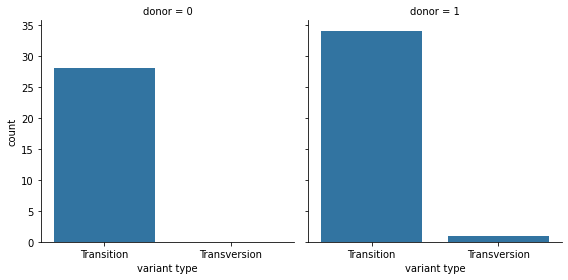

In [13]:
g = sns.FacetGrid(data=donor_spec_vcf_df, col="donor", height=4)
g.map_dataframe(sns.countplot, x="variant type")

g.fig.savefig(join(outdir, "variant_type_donor_vars.pdf"), bbox_inches='tight', pad_inches=0.5)

In [14]:
# g = sns.FacetGrid(data=all_vcf_df, col="donor")
# g.map_dataframe(sns.countplot, x="variant type")
# g

In [15]:
all_vcf_df.groupby(["donor", "variant type"]).size()

donor  variant type
0      Transition      67
       Transversion     1
1      Transition      67
       Transversion     1
dtype: int64

# B. Violinplot across conditions and donors of donor vars (colored by transition/transversion)

In [16]:
long_all_af = pd.merge(all_af, cells_meta.set_index("ID")[["condition", "donor"]], left_index=True, right_index=True).reset_index().melt(id_vars=["index", "condition", "donor"], var_name="Variant", value_name="AF")
long_all_af

long_all_af["variant type"] = long_all_af["Variant"].apply(lambda x: variant_df.loc[x, "variant type"])
long_all_af


,index,condition,donor,Variant,AF,variant type
0,AAACGAAAGAATCAAC-1_Control,Control,0,10397G,1.000000,Transition
1,AAACGAAAGCGAGAAA-1_Control,Control,0,10397G,1.000000,Transition
2,AAACGAAAGTACAGAT-1_Control,Control,0,10397G,0.000000,Transition
3,AAACGAAAGTTAGCAA-1_Control,Control,0,10397G,0.800000,Transition
4,AAACGAACACTCGCAG-1_Control,Control,0,10397G,1.000000,Transition
...,...,...,...,...,...,...
1176259,TTTGTGTCAATGACTC-1_Input,Input,1,9899C,1.000000,Transition
1176260,TTTGTGTCAGAAAGAG-1_Input,Input,1,9899C,0.715753,Transition
1176261,TTTGTGTCATAGCCAT-1_Input,Input,1,9899C,1.000000,Transition
1176262,TTTGTGTGTCATAGAA-1_Input,Input,1,9899C,0.988235,Transition


In [17]:
# g = sns.FacetGrid(data=long_all_af, col="donor", height=4)
# g.map_dataframe(sns.pointplot, y="AF", x="condition", hue="variant type", hue_order=["Transition", "Transversion"])
# plt.legend()
# g.fig.savefig(join(outdir, "variant_type_all_vars.pdf"), bbox_inches='tight', pad_inches=0.5)

# C. Transition vs transversion AF overall per donor

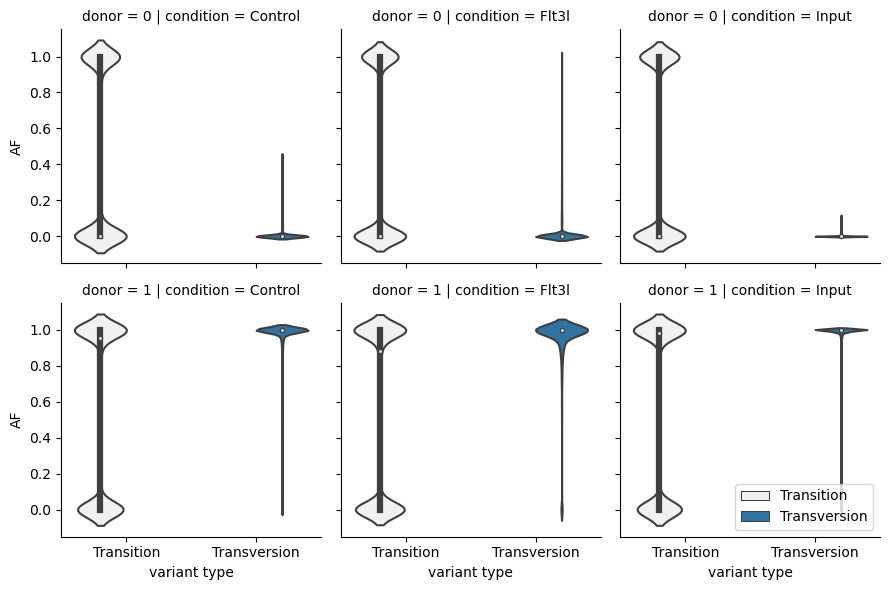

In [18]:
g = sns.FacetGrid(data=long_all_af, row="donor", col="condition", 
                  )
g.map_dataframe(sns.violinplot, y="AF", x= "variant type", hue="variant type", hue_order=["Transition", "Transversion"])
g.fig.savefig(join(outdir, "variant_af_all_vars_violin.pdf"), bbox_inches='tight', pad_inches=0.5)
plt.legend()

In [19]:
don_vars = []
for x in all_donor_vars:
    don_vars.extend(all_donor_vars[x])
don_vars = set(don_vars)
don_vars

{'10397G',
 '10463C',
 '10559G',
 '10589A',
 '11251G',
 '11719A',
 '11761T',
 '11812G',
 '13188T',
 '13368A',
 '14233G',
 '1438G',
 '146C',
 '14766T',
 '14905A',
 '150T',
 '15326G',
 '15452A',
 '15607G',
 '15928A',
 '16126C',
 '16294T',
 '16304C',
 '16355T',
 '16362C',
 '16519C',
 '1888A',
 '196C',
 '204C',
 '2442C',
 '263G',
 '2706G',
 '3847C',
 '4117C',
 '4216C',
 '4769G',
 '4917G',
 '5147A',
 '5580C',
 '58C',
 '64T',
 '7028T',
 '709A',
 '73G',
 '750G',
 '7598A',
 '827G',
 '8292A',
 '8461T',
 '8697A',
 '8860G',
 '930A'}

In [20]:
long_don_af = pd.merge(all_af.loc[:,all_af.columns.isin(don_vars)], cells_meta.set_index("ID")[["condition", "donor"]], left_index=True, right_index=True).reset_index().melt(id_vars=["index", "condition", "donor"], var_name="Variant", value_name="AF")
long_don_af
long_don_af = long_don_af[long_don_af["Variant"].isin(don_vars)]
long_don_af["variant type"] = long_don_af["Variant"].apply(lambda x: variant_df.loc[x, "variant type"])
long_don_af


,index,condition,donor,Variant,AF,variant type
0,AAACGAAAGAATCAAC-1_Control,Control,0,10397G,1.0,Transition
1,AAACGAAAGCGAGAAA-1_Control,Control,0,10397G,1.0,Transition
2,AAACGAAAGTACAGAT-1_Control,Control,0,10397G,0.0,Transition
3,AAACGAAAGTTAGCAA-1_Control,Control,0,10397G,0.8,Transition
4,AAACGAACACTCGCAG-1_Control,Control,0,10397G,1.0,Transition
...,...,...,...,...,...,...
899491,TTTGTGTCAATGACTC-1_Input,Input,1,930A,1.0,Transition
899492,TTTGTGTCAGAAAGAG-1_Input,Input,1,930A,1.0,Transition
899493,TTTGTGTCATAGCCAT-1_Input,Input,1,930A,1.0,Transition
899494,TTTGTGTGTCATAGAA-1_Input,Input,1,930A,1.0,Transition


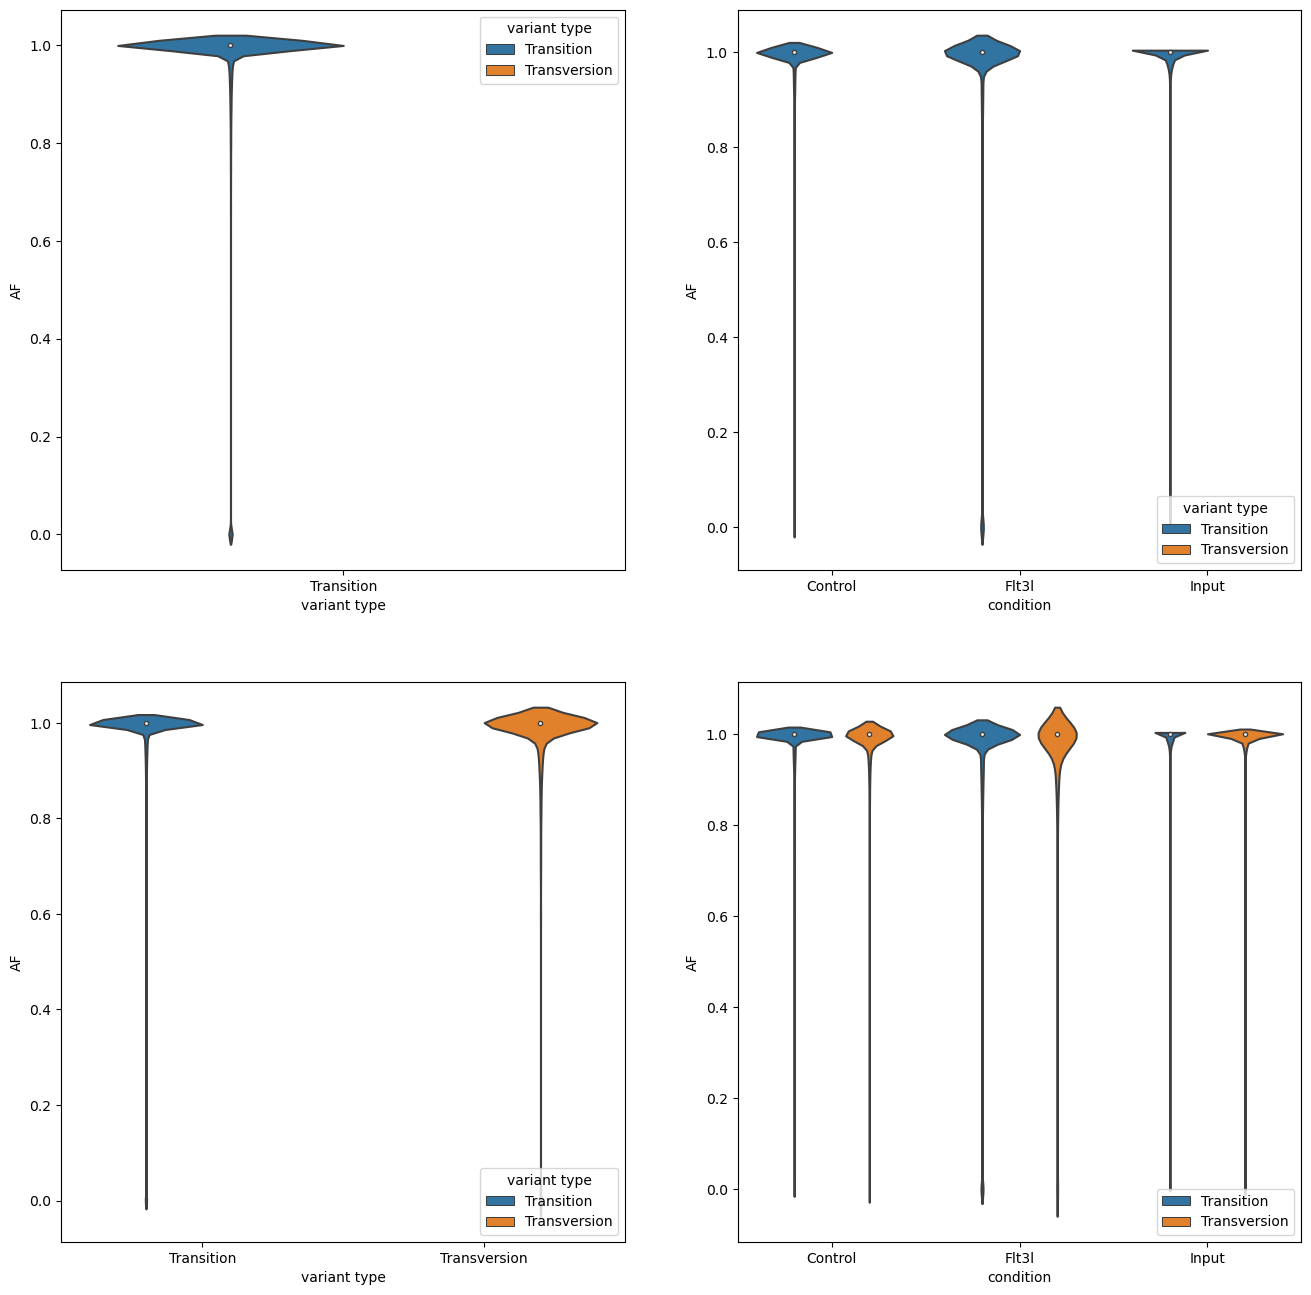

In [21]:
f, ax = plt.subplots(figsize=(16,16), nrows=len(all_donor_vars),ncols=2, sharex=False, sharey=False)#squeeze=True)
for d, val in long_don_af.groupby("donor"):
    val = val[val["Variant"].isin(all_donor_vars[d])]
    #g = sns.FacetGrid(data=long_don_af, row="donor", col="condition")
    #g.map_dataframe(sns.violinplot, y="AF", x= "variant type", hue="variant type", hue_order=["Transition", "Transversion"])

    sns.violinplot(data=val, y="AF", x= "variant type", hue="variant type", hue_order=["Transition", "Transversion"], ax=ax[d,0])
    sns.violinplot(data=val, y="AF", x= "condition", hue="variant type", hue_order=["Transition", "Transversion"], ax=ax[d,1])
plt.legend()
plt.savefig(join(outdir, "variant_af_donor_vars_violin.pdf"), bbox_inches='tight', pad_inches=0.5)